# Imports

In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
!ls

ML.ipynb              metadata.csv          results_no_cc.csv
Multiple Models.ipynb plot.ipynb            test_data.csv
metadata-v0.csv       results_after_cc.csv


## Load datasets

In [3]:
cols = ['filename', 'R', 'G', 'B']
df_colors = pd.read_csv("results_after_cc.csv", usecols=cols)
df_colors.head()

,filename,R,G,B
0,SP2-B201-G-H6.jpg,172.361810,165.366335,133.213213
1,SP2-B201-G-H7.jpg,212.727602,210.037285,188.344796
2,SP2-B201-G-H20.jpg,169.052670,163.957104,140.482534
3,SP2-B201-G-H5.jpg,238.161991,239.019910,233.287421
4,SP2-B201-G-H4.jpg,234.089231,231.791493,221.808869


In [4]:
df_metadata = pd.read_csv("metadata.csv")
df_metadata.sample(5)

,filename,BC
17,SP2-B201-G-H19.jpg,6.320
27,SP2-B201-G-H8.jpg,15.482
41,SP2-B201-G-L5.jpg,3.900
12,SP2-B201-G-H14.jpg,8.227
2,SP1-B201-G-3.jpg,2.088


In [5]:
df_with_BC = pd.merge(df_colors, df_metadata, on=["filename"])
df_with_BC.head()

,filename,R,G,B,BC
0,SP2-B201-G-H6.jpg,172.361810,165.366335,133.213213,7.801
1,SP2-B201-G-H7.jpg,212.727602,210.037285,188.344796,2.847
2,SP2-B201-G-H20.jpg,169.052670,163.957104,140.482534,7.294
3,SP2-B201-G-H5.jpg,238.161991,239.019910,233.287421,0.928
4,SP2-B201-G-H4.jpg,234.089231,231.791493,221.808869,1.335


# EDA

In [6]:
# !pip install "pandas-profiling[notebook]"

In [6]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df_with_BC.query('BC < 2.5'), title="Pandas Profiling Report")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Divide entries with low BC concentration

In [8]:
df_with_BC.describe()

,R,G,B,BC
count,45.000000,45.000000,45.000000,45.000000
mean,199.713927,195.978976,178.319252,4.441400
std,32.791226,33.725244,39.610030,3.640268
min,123.148959,119.608688,95.847240,0.163000
25%,172.553303,168.214118,147.985158,1.678000
50%,202.045430,200.214480,178.830045,3.761000
75%,226.870045,220.843982,208.063529,6.320000
max,248.287059,247.700452,245.883439,15.482000


## Low BC concentrations (values less than or equal to 2)

In [9]:
df_low_BC = df_with_BC.query('BC <= 2')
df_low_BC.describe()

,R,G,B,BC
count,15.000000,15.000000,15.000000,15.000000
mean,234.116477,231.241484,220.752772,1.133200
std,8.898805,10.721701,16.382355,0.540199
min,220.447421,213.501900,188.697376,0.163000
25%,227.111493,220.689321,207.673303,0.741500
50%,234.089231,231.791493,218.390769,1.294000
75%,240.036742,239.930226,233.667964,1.594500
max,248.287059,247.700452,245.883439,1.880000


## Higher BC concentrations (values greater than 2)

In [10]:
df_high_BC = df_with_BC.query('BC > 2')
df_high_BC.describe()

,R,G,B,BC
count,30.000000,30.000000,30.000000,30.000000
mean,182.512652,178.347722,157.102492,6.095500
std,25.979732,26.560525,29.221551,3.387292
min,123.148959,119.608688,95.847240,2.088000
25%,169.994525,164.309412,137.458824,3.795750
50%,188.245520,183.389683,159.804615,5.125000
75%,201.606290,199.594570,178.496425,7.739000
max,226.870045,225.621357,211.805068,15.482000


## Extract R, G, B values as X,  and BC values as y

In [11]:
X_low, y_low = df_low_BC.iloc[:,1:-1], df_low_BC.iloc[:,-1]
X_low.head(), y_low.head()

(             R           G           B
 3   238.161991  239.019910  233.287421
 4   234.089231  231.791493  221.808869
 7   222.951312  220.534661  207.283077
 9   222.952217  220.085973  204.467511
 10  239.720905  240.840543  234.048507,
 3     0.928
 4     1.335
 7     1.678
 9     1.725
 10    0.816
 Name: BC, dtype: float64)

In [12]:
X_high, y_high = df_high_BC.iloc[:,1:-1], df_high_BC.iloc[:,-1]
X_high.head(), y_high.head()

(            R           G           B
 0  172.361810  165.366335  133.213213
 1  212.727602  210.037285  188.344796
 2  169.052670  163.957104  140.482534
 5  172.445068  168.214118  150.846154
 6  176.408326  171.548416  152.129955,
 0    7.801
 1    2.847
 2    7.294
 5    8.089
 6    6.320
 Name: BC, dtype: float64)

## ML with Scikit-Learn

In [13]:
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # true, pred

## Train/Test split and R value extraction

In [14]:
random_state = 42

X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y_low, random_state=random_state)
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, random_state=random_state)

print("BC values <= 2\n")
print("Train size: ", len(X_low_train), "Test size: ", len(X_low_test))

print("\n\nBC values > 2\n")
print("Train size: ", len(X_high_train), "Test size: ", len(X_high_test))


R_low_train = X_low_train.iloc[:, 0].values.reshape(-1, 1)
R_low_test = X_low_test.iloc[:, 0].values.reshape(-1, 1)

R_high_train = X_high_train.iloc[:, 0].values.reshape(-1, 1)
R_high_test = X_high_test.iloc[:, 0].values.reshape(-1, 1)

BC values <= 2

Train size:  11 Test size:  4


BC values > 2

Train size:  22 Test size:  8


## Create 2d representations for the exponential models

In [16]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)

poly_train_features_low_bc = poly.fit_transform(R_low_train)
poly_test_features_low_bc = poly.fit_transform(R_low_test)

poly_train_features_high_bc = poly.fit_transform(R_high_train)
poly_test_features_high_bc = poly.fit_transform(R_high_test)

## Create Linear and exponential Models

In [20]:
from pprint import pprint
from sklearn.linear_model import LinearRegression, RidgeCV, Lasso

from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor

scoring = ("r2", "neg_mean_absolute_error", "neg_mean_squared_error", "neg_root_mean_squared_error")


lr_low = LinearRegression()
lr_high = LinearRegression()

exp_low = LinearRegression()
exp_high = LinearRegression()

ridge_low = RidgeCV()
ridge_high = RidgeCV()

### Low concentration models

In [65]:
print("Linear Model")
pprint(cross_validate(lr_low, R_low_train, y_low_train, cv=2, scoring=scoring))

print("\nRidge Model")
pprint(cross_validate(ridge_low, R_low_train, y_low_train, cv=2, scoring=scoring))

print("\nExponential Model")
pprint(cross_validate(exp_low, poly_train_features_low_bc, y_low_train, cv=2, scoring=scoring))

Linear Model
{'fit_time': array([0.01438093, 0.00178885]),
 'score_time': array([0.00311613, 0.00212812]),
 'test_neg_mean_absolute_error': array([-0.11356364, -0.14269104]),
 'test_neg_mean_squared_error': array([-0.01890129, -0.02387228]),
 'test_neg_root_mean_squared_error': array([-0.13748196, -0.15450656]),
 'test_r2': array([0.92665938, 0.93100338])}

Ridge Model
{'fit_time': array([0.00283194, 0.0012207 ]),
 'score_time': array([0.002038  , 0.00195718]),
 'test_neg_mean_absolute_error': array([-0.10442182, -0.14273293]),
 'test_neg_mean_squared_error': array([-0.01595957, -0.02388984]),
 'test_neg_root_mean_squared_error': array([-0.12633118, -0.15456337]),
 'test_r2': array([0.93807382, 0.93095263])}

Exponential Model
{'fit_time': array([0.01559496, 0.00165892]),
 'score_time': array([0.00183821, 0.00151014]),
 'test_neg_mean_absolute_error': array([-0.05107919, -0.08368248]),
 'test_neg_mean_squared_error': array([-0.00334095, -0.00987304]),
 'test_neg_root_mean_squared_error

### Higher concentration models

In [66]:
print("Linear Model")
pprint(cross_validate(lr_high, R_high_train, y_high_train, cv=2, scoring=scoring))

print("\nRidge Model")
pprint(cross_validate(ridge_high, R_high_train, y_high_train, cv=2, scoring=scoring))

print("\nExponential Model")
pprint(cross_validate(exp_high, poly_train_features_high_bc, y_high_train, cv=2, scoring=scoring))

Linear Model
{'fit_time': array([0.00130415, 0.0013051 ]),
 'score_time': array([0.00247979, 0.00145602]),
 'test_neg_mean_absolute_error': array([-0.8607407 , -0.68702809]),
 'test_neg_mean_squared_error': array([-1.80096266, -0.77185372]),
 'test_neg_root_mean_squared_error': array([-1.3419995 , -0.87855206]),
 'test_r2': array([0.84837072, 0.90635804])}

Ridge Model
{'fit_time': array([0.0017221 , 0.00153399]),
 'score_time': array([0.00136399, 0.00116706]),
 'test_neg_mean_absolute_error': array([-0.85979361, -0.68702864]),
 'test_neg_mean_squared_error': array([-1.80485841, -0.77182461]),
 'test_neg_root_mean_squared_error': array([-1.34345019, -0.87853549]),
 'test_r2': array([0.84804272, 0.90636157])}

Exponential Model
{'fit_time': array([0.00178289, 0.00121021]),
 'score_time': array([0.0014832 , 0.00122285]),
 'test_neg_mean_absolute_error': array([-0.84030273, -0.95461797]),
 'test_neg_mean_squared_error': array([-1.56839981, -1.22578073]),
 'test_neg_root_mean_squared_error

## Fit Model


Low BC model Test Scores:
R2 = 0.9348305656194467 
MAE = 0.12863751113011634 
RMSE = 0.14026082346889818


Higher BC model Test Scores:
R2 = 0.5921635012642037 
MAE = 1.044157063192194 
RMSE = 1.2898472966949839


Low BC Exponential model Test Scores:
R2 = 0.9042761357871196 
MAE = 0.14736803694914596 
RMSE = 0.1699904484050376


Higher BC Exponential model Test Scores:
R2 = 0.7143650533411503 
MAE = 0.856697496046 
RMSE = 1.0794460053078085



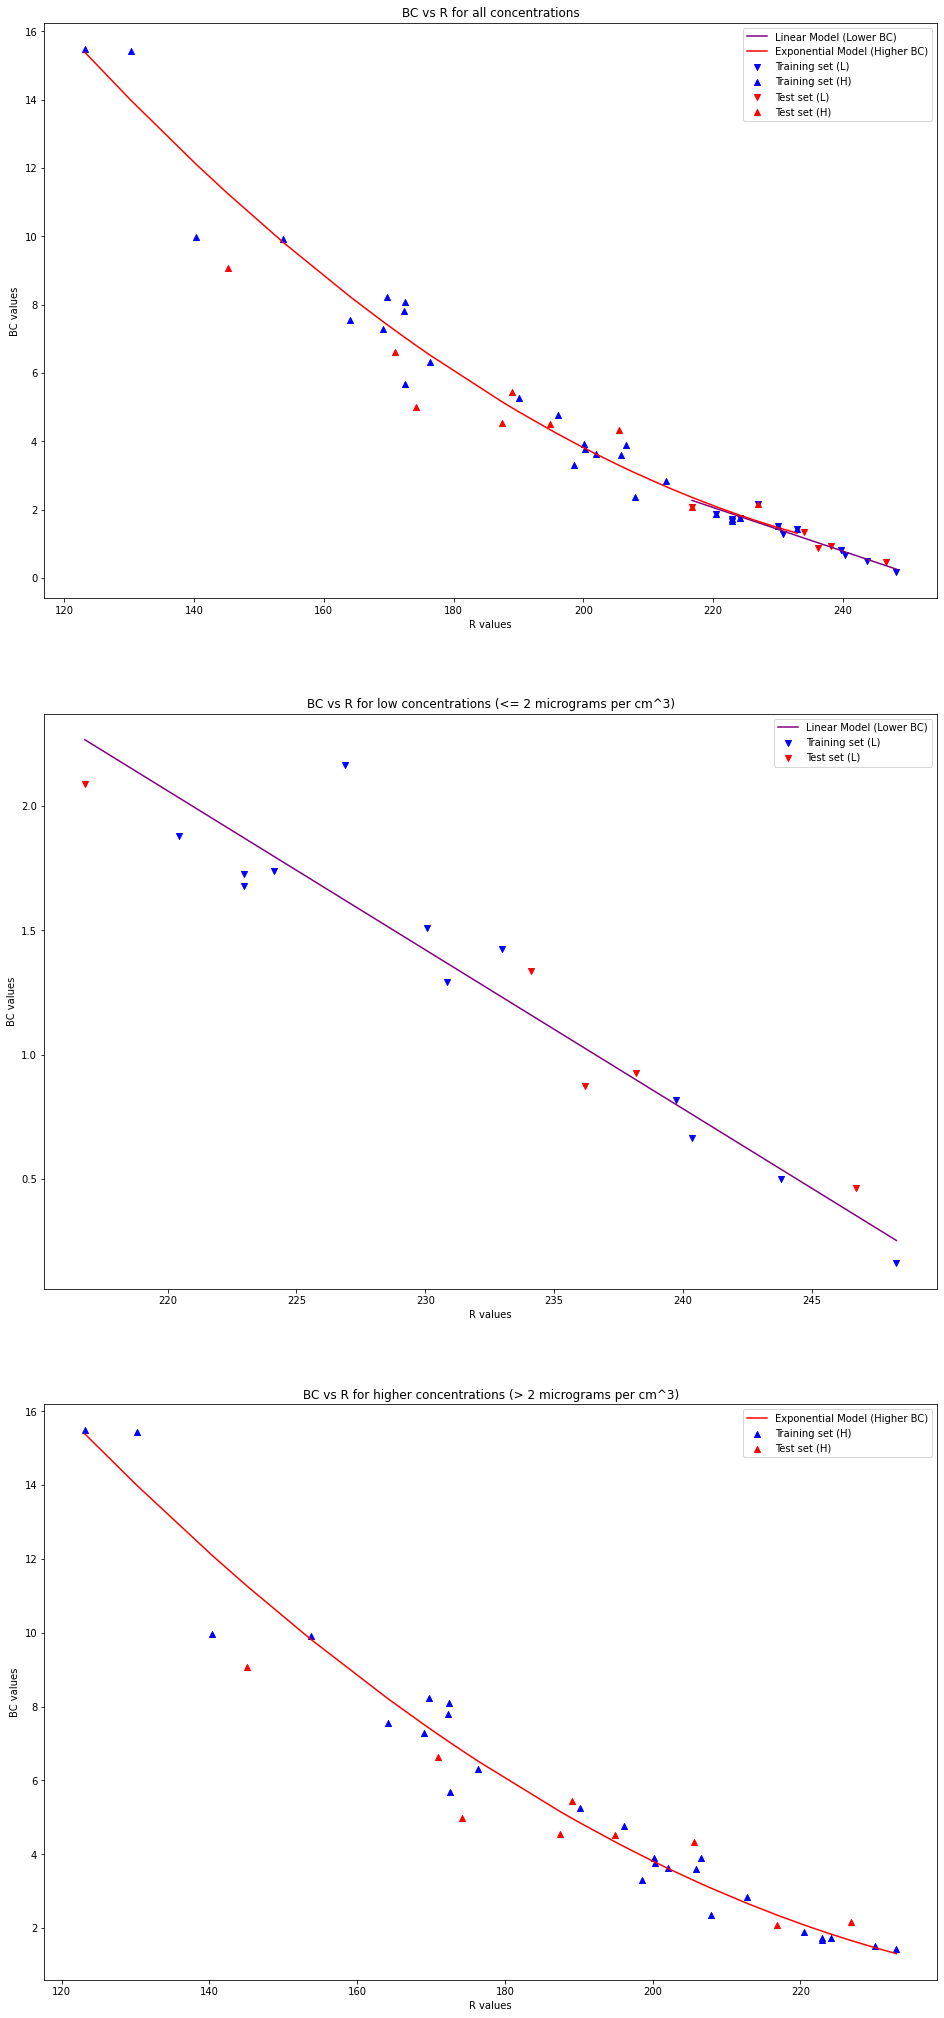

In [29]:
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # true, pred


class BC_Model:
    model = BC_Model("results_after_cc.csv", "metadata.csv", 2, 0.2, 0.6)
    def __init__(self, path_to_dataset, path_to_metadata, threshold=2, threshold_delta_low=0, threshold_delta_high=0):
        """
        Constructor for BC Model
        """
        
        random_state = 42
        self.threshold = threshold

        # Model Initialization        
        self.classifier = LogisticRegression()
        self.low_bc_model    = RidgeCV()
        self.higher_bc_model = LinearRegression()
        
        self.low_bc_model_2d    = LinearRegression()
        self.higher_bc_model_2d = LinearRegression()
        
        df_Rs = pd.read_csv(path_to_dataset, usecols=['filename', 'R'])
        df_metadata = pd.read_csv(path_to_metadata)
        data = pd.merge(df_Rs, df_metadata, on=["filename"])
        
        df_low_BC  = data.query(f'BC <= {threshold + threshold_delta_low}')
        df_high_BC = data.query(f'BC > {threshold - threshold_delta_high}')
        
        df_low_or_high = data.copy()
        df_low_or_high["is_low"] = df_low_or_high["BC"] <= threshold 
        df_low_or_high.drop(["filename", "BC"], axis=1, inplace=True)

        X_clf, y_clf = df_low_or_high.iloc[:,0], df_low_or_high.iloc[:,-1]
        self.X_low, y_low = df_low_BC.iloc[:,1:-1], df_low_BC.iloc[:,-1]
        self.X_high, y_high = df_high_BC.iloc[:,1:-1], df_high_BC.iloc[:,-1]
        
        # Train/Test Split                 
        self.X_clf_train, self.X_clf_test, self.y_clf_train, self.y_clf_test = train_test_split(X_clf, y_clf, random_state=random_state)
        X_low_train, X_low_test, self.y_low_train, self.y_low_test = train_test_split(self.X_low, y_low, random_state=random_state)
        X_high_train, X_high_test, self.y_high_train, self.y_high_test = train_test_split(self.X_high, y_high, random_state=random_state)
        
        
        self.X_clf_train, self.X_clf_test = self.X_clf_train.values.reshape(-1, 1), self.X_clf_test.values.reshape(-1, 1)
        self.R_low_train = X_low_train.iloc[:, 0].values.reshape(-1, 1)
        self.R_low_test = X_low_test.iloc[:, 0].values.reshape(-1, 1)

        self.R_high_train = X_high_train.iloc[:, 0].values.reshape(-1, 1)
        self.R_high_test = X_high_test.iloc[:, 0].values.reshape(-1, 1)
    

        self.poly = PolynomialFeatures(degree=2, include_bias=False)

        self.R_low_train_2d = self.poly.fit_transform(self.R_low_train)
        self.R_low_test_2d = self.poly.fit_transform(self.R_low_test)
        
        self.R_high_train_2d = self.poly.fit_transform(self.R_high_train)
        self.R_high_test_2d = self.poly.fit_transform(self.R_high_test)
        
    
    def fit(self):
        
        self.classifier = self.classifier.fit(self.X_clf_train, self.y_clf_train)
        
        self.low_bc_model = self.low_bc_model.fit(self.R_low_train, self.y_low_train)
        self.higher_bc_model = self.higher_bc_model.fit(self.R_high_train, self.y_high_train)
        
        self.low_bc_model_2d = self.low_bc_model_2d.fit(self.R_low_train_2d, self.y_low_train)
        self.higher_bc_model_2d = self.higher_bc_model_2d.fit(self.R_high_train_2d, self.y_high_train)
        
        
    def score(self):
        y_clf_test = self.y_clf_test
        y_low_test, y_high_test = self.y_low_test, self.y_high_test
    
        
        y_low_pred = self.low_bc_model.predict(self.R_low_test)
        y_high_pred = self.higher_bc_model.predict(self.R_high_test)
        
        y_low_pred_2d = self.low_bc_model_2d.predict(self.R_low_test_2d)
        y_high_pred_2d = self.higher_bc_model_2d.predict(self.R_high_test_2d)
        
        r2_low, mae_low, mse_low = r2_score(y_low_test, y_low_pred), mean_absolute_error(y_low_test, y_low_pred), mean_squared_error(y_low_test, y_low_pred)
        r2_high, mae_high, mse_high = r2_score(y_high_test, y_high_pred), mean_absolute_error(y_high_test, y_high_pred), mean_squared_error(y_high_test, y_high_pred)
        
        r2_low_2d, mae_low_2d, mse_low_2d = r2_score(y_low_test, y_low_pred_2d), mean_absolute_error(y_low_test, y_low_pred_2d), mean_squared_error(y_low_test, y_low_pred_2d)
        r2_high_2d, mae_high_2d, mse_high_2d = r2_score(y_high_test, y_high_pred_2d), mean_absolute_error(y_high_test, y_high_pred_2d), mean_squared_error(y_high_test, y_high_pred_2d)
        
        print("\nLow BC model Test Scores:")
        print(f"R2 = {r2_low} \nMAE = {mae_low} \nRMSE = {np.sqrt(mse_low)}\n")
        
        print("\nHigher BC model Test Scores:")
        print(f"R2 = {r2_high} \nMAE = {mae_high} \nRMSE = {np.sqrt(mse_high)}\n")
        
        print("\nLow BC Exponential model Test Scores:")
        print(f"R2 = {r2_low_2d} \nMAE = {mae_low_2d} \nRMSE = {np.sqrt(mse_low_2d)}\n")
        
        print("\nHigher BC Exponential model Test Scores:")
        print(f"R2 = {r2_high_2d} \nMAE = {mae_high_2d} \nRMSE = {np.sqrt(mse_high_2d)}\n")
        
        
    def plot(self):
        %matplotlib inline
        fig, ax = plt.subplots(3, 1, figsize=(16, 36))
        axes = ax.ravel()
        axes[0].set_title("BC vs R for all concentrations")
        axes[1].set_title(f"BC vs R for low concentrations (<= {self.threshold} micrograms per cm^3)")
        axes[2].set_title(f"BC vs R for higher concentrations (> {self.threshold} micrograms per cm^3)")
        
        axes[0].set_xlabel("R values")
        axes[0].set_ylabel("BC values")
        
        axes[1].set_xlabel("R values")
        axes[1].set_ylabel("BC values")
        
        axes[2].set_xlabel("R values")
        axes[2].set_ylabel("BC values")
        
        
        axes[0].scatter(self.R_low_train, self.y_low_train, c="blue", marker="v", label="Training set (L)")
        axes[0].scatter(self.R_high_train, self.y_high_train, c="blue", marker="^", label="Training set (H)")
        axes[0].scatter(self.R_low_test, self.y_low_test, c="red", marker="v", label="Test set (L)")
        axes[0].scatter(self.R_high_test, self.y_high_test, c="red", marker="^", label="Test set (H)")
        
        axes[1].scatter(self.R_low_train, self.y_low_train, c="blue", marker="v", label="Training set (L)")
        axes[1].scatter(self.R_low_test, self.y_low_test, c="red", marker="v", label="Test set (L)")
        
        axes[2].scatter(self.R_high_train, self.y_high_train, c="blue", marker="^", label="Training set (H)")
        axes[2].scatter(self.R_high_test, self.y_high_test, c="red", marker="^", label="Test set (H)")
    
        
        R_low = self.X_low.iloc[:, 0].values.reshape(-1, 1)
        R_high = self.X_high.iloc[:, 0].values.reshape(-1, 1)
        
        low_bc_pred = self.low_bc_model.predict(R_low)
        higher_bc_pred = self.higher_bc_model_2d.predict(self.poly.fit_transform(R_high))
        
        df_plot_low = pd.DataFrame({'R': R_low[:, 0], 'BC_Pred': low_bc_pred})
        df_plot_low.sort_values(by=['R'], inplace=True)        
        df_plot_high = pd.DataFrame({'R': R_high[:, 0], 'BC_Pred': higher_bc_pred})
        df_plot_high.sort_values(by=['R'], inplace=True)

        
        axes[0].plot(df_plot_low["R"], df_plot_low["BC_Pred"], c="purple", label="Linear Model (Lower BC)")
        axes[0].plot(df_plot_high["R"], df_plot_high["BC_Pred"], c="red", label="Exponential Model (Higher BC)")
        
        axes[1].plot(df_plot_low["R"], df_plot_low["BC_Pred"], c="purple", label="Linear Model (Lower BC)")
        axes[2].plot(df_plot_high["R"], df_plot_high["BC_Pred"], c="red", label="Exponential Model (Higher BC)")

        axes[0].legend()
        axes[1].legend()
        axes[2].legend()
        plt.show()
    
    
    def predict(self, R_test, R_threshold=220):
        result = []
        for datapoint in R_test:
            pred = []
            if(datapoint[0] >= R_threshold):
                pred = self.low_bc_model.predict([datapoint])
            else:
                rep_2d = self.poly.fit_transform([datapoint])
                pred = self.higher_bc_model_2d.predict(rep_2d)
            result.append(pred[0])
        return result
    
    
    def export(self, filename):
        with open(filename, 'wb') as file:
            pickle.dump(self, file)
        print(f"Model written to: {filename}")



model = BC_Model("results_after_cc.csv", "metadata.csv", 2, 0.2, 0.6)
model.fit()
model.score()
model.plot()


# model.export("multi_step_model.mdl")
